# Sales forecating

### 1. Some descriptive statistics
#### a. General data set overveiw
#### b. Preliminary forecating of sales
### 2. ABC analysis by Products
#### a. sklearn models sales forecating
#### b. sktime models sales forecating
### 3. ABC analysis by Customers
#### a. sktime models sales forecating

In [ ]:
# Loading libraries and data

In [184]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sktime.utils.plotting import plot_series

In [185]:
df = pd.read_excel('practice.xlsx')
df.shape

(27994, 6)

## 1. Some descriptive statistics

In [ ]:
# Structure of dataframe

In [186]:
df.head()

,Product,Customer,Order,Qty,Sales,Period
0,Product 1,Customer 1,78542,1,3.337209,01.07.2019 09:25:47
1,Product 2,Customer 2,78554,1,6.093023,02.07.2019 09:42:14
2,Product 3,Customer 2,78554,1,3.193023,02.07.2019 09:42:14
3,Product 4,Customer 2,78554,1,6.297674,02.07.2019 09:42:14
4,Product 5,Customer 3,78578,1,9.558140,01.07.2019 14:40:51


In [ ]:
# Checking empty values

In [187]:
df.isnull().sum()

Product     0
Customer    0
Order       0
Qty         0
Sales       0
Period      0
dtype: int64

In [ ]:
# Removing zero orders from dataframe

In [188]:
print('Orders with 0 quantity: ', df[df['Qty'] == 0].count()[0])
df.drop(df[df['Qty'] == 0].index, inplace=True, axis=0)

Orders with 0 quantity:  21


In [ ]:
# Converting column Period into datetime format

In [189]:
df['Period'] = pd.to_datetime(df['Period'])
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27973 entries, 0 to 27993
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   Product   27973 non-null  object        
 1   Customer  27973 non-null  object        
 2   Order     27973 non-null  object        
 3   Qty       27973 non-null  int64         
 4   Sales     27973 non-null  float64       
 5   Period    27973 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(3)
memory usage: 1.5+ MB


In [ ]:
# Calculation of the period of time

In [190]:
print('Start date: ', df['Period'].min(),', End date: ', df['Period'].max())
period=df['Period'].max() - df['Period'].min()

print('Period of time: ', period// np.timedelta64(1, 'Y'), 'years, ', (period % np.timedelta64(1, 'Y'))// np.timedelta64(1, 'M'), 'months, ', ((period % np.timedelta64(1, 'Y'))% np.timedelta64(1, 'M'))// np.timedelta64(1, 'D'), 'days.')

Start date:  2018-01-11 00:00:00 , End date:  2021-12-02 17:41:42
Period of time:  3 years,  10 months,  21 days.


### 1.a. General data set overveiw

In [ ]:
# Calculation of the annual sum of sales

In [191]:
df.groupby(df['Period'].dt.year)['Sales'].sum()

Period
2018     18380.820930
2019    218160.558140
2020    255356.976744
2021     29301.818605
Name: Sales, dtype: float64

Text(0.5, 1.0, 'Annual sales')

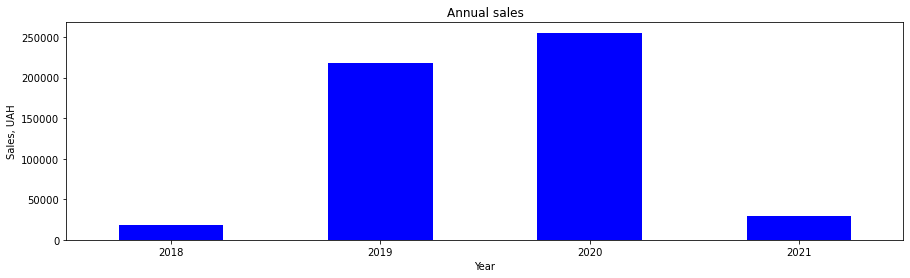

In [192]:
fig, axs = plt.subplots(figsize=(15, 4))
df.groupby(df["Period"].dt.year)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='blue')
plt.xlabel('Year')
plt.ylabel('Sales, UAH')
plt.title("Annual sales")

**Conclusion 1. Annual sales grow starting from 2018 till 2020.**

In [ ]:
# As dataframe includes current year 2021, the plot above does not give us a full picture. 
# Therefore, we need to look at monthly sales, for example total sales in January each year.

In [193]:
df1 = df[df['Period'].dt.month == 1]
df1.groupby(df['Period'].dt.year)['Sales'].sum()

Period
2018      550.348837
2019    18370.146512
2020    13297.486047
2021    10366.723256
Name: Sales, dtype: float64

Text(0.5, 1.0, 'January sales')

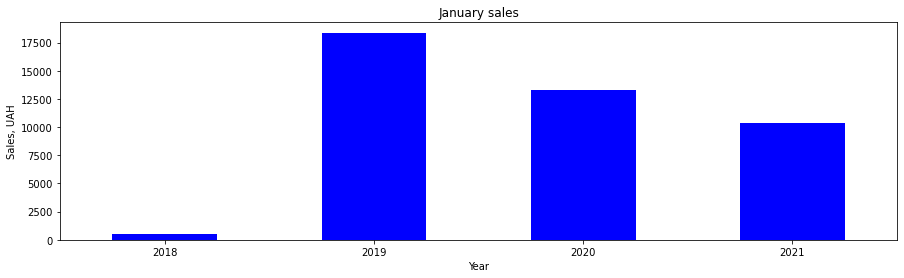

In [194]:
fig, axs = plt.subplots(figsize=(15, 4))
df1.groupby(df["Period"].dt.year)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='blue')
plt.xlabel('Year')
plt.ylabel('Sales, UAH')
plt.title("January sales")

**Conclusion 2. Despite the positive trend in annual sales in 2018-2020, January sales illustrate negative trend in 2019-2021.**

In [ ]:
# Analysis of the monthly sales

Text(0.5, 1.0, 'Total monthly sales')

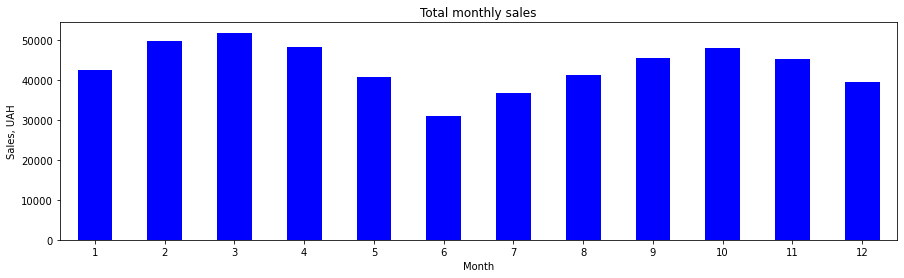

In [195]:
fig, axs = plt.subplots(figsize=(15, 4))
df.groupby(df["Period"].dt.month)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='blue')

plt.xlabel("Month");
plt.ylabel("Sales, UAH");
plt.title("Total monthly sales")

**Conclusion 3. We clearly observe dependence of the sales on the months**

In [ ]:
# Analysis of the daily sales

Text(0.5, 1.0, 'Total daily sales')

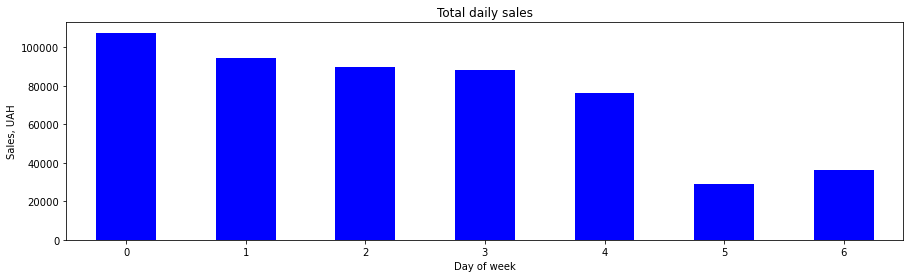

In [196]:
fig, axs = plt.subplots(figsize=(15, 4))
df.groupby(df["Period"].dt.dayofweek)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='blue')

plt.xlabel("Day of week");
plt.ylabel("Sales, UAH");
plt.title("Total daily sales")

**Conclusion 4. At the weekends we observe lower sales than on workdays. Within the workday sales decrease from Monday to Friday**

In [ ]:
# Analysis of the hourly sales

Text(0.5, 1.0, 'Total hourly sales')

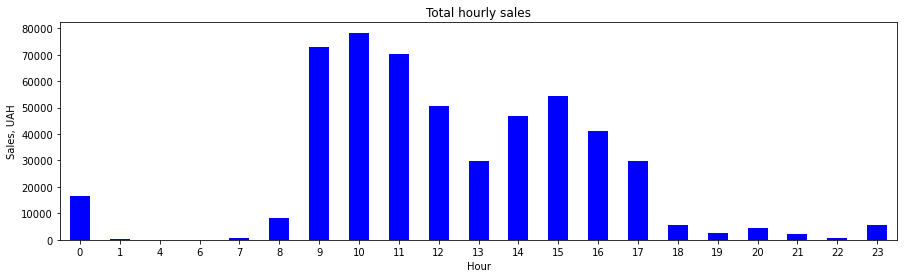

In [197]:
fig, axs = plt.subplots(figsize=(15, 4))
df.groupby(df["Period"].dt.hour)["Sales"].sum().plot(kind='bar', rot=0, ax=axs, color='blue')

plt.xlabel("Hour");
plt.ylabel("Sales, UAH");
plt.title("Total hourly sales")

**Conclusion 5. The hourly sales can be divided into 3 ranges: maximum sales before the afternoon with peak at 10 a.m., afternoon with peak at 3 p.m., and almost negligible sales in the period from 7 p.m. till 7 a.m. However, there is a local peak at midnight.**

### 1.b. Preliminary forecating of sales

In [198]:
dff=df.copy()
dff.drop(['Product', 'Customer', 'Order', 'Qty'], inplace=True, axis=1)
dff = dff[dff['Period'] > '2018-12-31'] 
dff = dff[dff['Period'] < '2021-01-01'] 

In [199]:
dff['Period'] = pd.to_datetime(dff['Period']).dt.strftime('%Y-%m')
dff['Period'] = pd.to_datetime(dff['Period'])
dff.head()

,Sales,Period
0,3.337209,2019-01-01
1,6.093023,2019-02-01
2,3.193023,2019-02-01
3,6.297674,2019-02-01
4,9.558140,2019-01-01


In [200]:
dff_ = dff.pivot_table(index="Period", values="Sales",  aggfunc=np.sum)
dff_.index = dff_.index.to_period(freq='M')
dff_.fillna(0.01, inplace=True)
dff_.head()

,Sales
Period,
2019-01,18370.146512
2019-02,19760.304651
2019-03,19532.106977
2019-04,18611.074419
2019-05,17650.555814


In [201]:
y1 = dff_.squeeze()

In [ ]:
# now let us plot the sales vs. months

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sales'>)

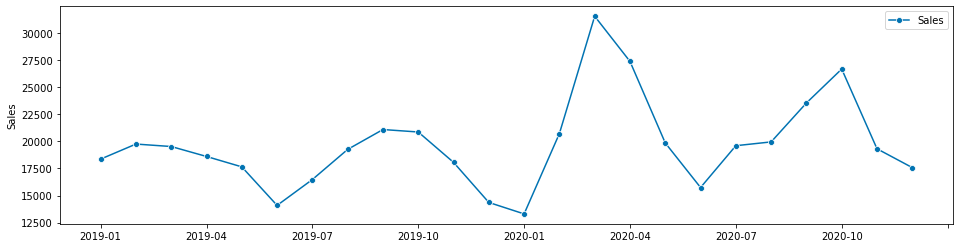

In [202]:
plot_series(y1, labels=["Sales"])

In [203]:
from sktime.forecasting.base import ForecastingHorizon

from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sales'>)

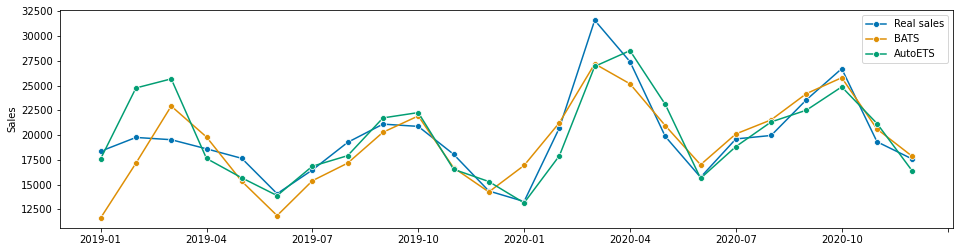

In [204]:
forecaster1 = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster2 = AutoETS(auto=True, sp=12, n_jobs=-1)

forecaster1.fit(y1)
forecaster2.fit(y1)

fh = ForecastingHorizon(y1.index, is_relative=False)
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)

plot_series(y1, y_pred1, y_pred2, labels=["Real sales", "BATS", "AutoETS"])


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:ylabel='Sales'>)

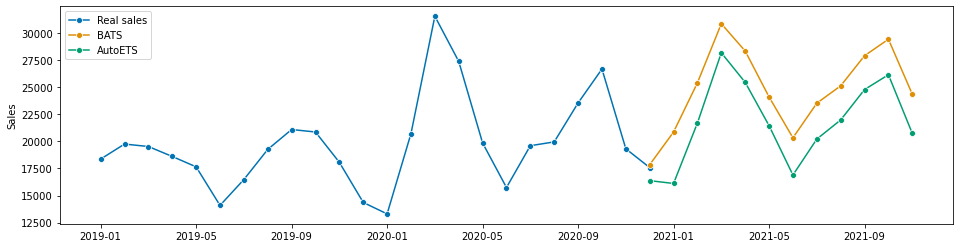

In [205]:
fh = np.arange(0, 12)
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)

plot_series(y1, y_pred1, y_pred2, labels=["Real sales", "BATS", "AutoETS"])

#### Conclusion. We can see the general trend, but 2 models provide different absolute values. Let us look in more details

## 2. ABC analysis by Products

In [ ]:
# Modifying the dataset: looking at year 2020, and taking needed columns

In [206]:
df1 = df[df['Period'] > '2019-12-31']
df1 = df1[df1['Period'] < '2021-01-01']
df1 = df1[['Product', 'Sales', 'Qty', 'Period']]
df1.head()

,Product,Sales,Qty,Period
12266,Product 1097,26.467442,1,2020-01-21 13:01:25
12267,Product 1098,24.246512,1,2020-01-21 13:01:25
12268,Product 673,71.095349,1,2020-01-21 13:01:25
12269,Product 699,53.583721,1,2020-01-21 13:01:25
12284,Product 82,209.432558,4,2020-03-03 12:05:27


In [ ]:
# Getting sum of sales of products and sorting them

In [207]:
df2 = df1.groupby('Product')['Sales', 'Qty'].sum().reset_index()
df2.sort_values('Sales', inplace=True, ascending = False)
df2.head()

<ipython-input-207-44a43ec62880>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df2 = df1.groupby('Product')['Sales', 'Qty'].sum().reset_index()


,Product,Sales,Qty
144,Product 23,23283.506977,1119
256,Product 58,20897.113953,1049
160,Product 25,17082.448837,2895
3,Product 101,10483.300000,505
290,Product 76,8474.913953,262


In [ ]:
# Calculating the total amount of sales

In [208]:
total_sales = df2['Sales'].sum()
total_sales

255367.83953488388

In [ ]:
# Calculating the Fraction in %

In [209]:
df2['Fraction'] = df2['Sales']/total_sales*100
df2.head(2)

,Product,Sales,Qty,Fraction
144,Product 23,23283.506977,1119,9.117635
256,Product 58,20897.113953,1049,8.183142


In [ ]:
# Calculating the accumullated Fraction in %

In [210]:
df2['Percent'] = df2['Fraction'].cumsum()
df2.head(2)

,Product,Sales,Qty,Fraction,Percent
144,Product 23,23283.506977,1119,9.117635,9.117635
256,Product 58,20897.113953,1049,8.183142,17.300777


In [ ]:
# Structuring the products into A,B,C categories

In [211]:
def group(perc):
    if perc <= 80:
        return 'A'
    elif perc > 80 and perc <= 95:
        return 'B'
    else:
        return 'C'

df2['ABC_category'] = df2['Percent'].map(group) #adding the category
df2.head()

,Product,Sales,Qty,Fraction,Percent,ABC_category
144,Product 23,23283.506977,1119,9.117635,9.117635,A
256,Product 58,20897.113953,1049,8.183142,17.300777,A
160,Product 25,17082.448837,2895,6.689350,23.990127,A
3,Product 101,10483.300000,505,4.105176,28.095304,A
290,Product 76,8474.913953,262,3.318708,31.414012,A


In [ ]:
# Calculating the number of products in each category and vizualizing this distribution

In [212]:
df2['ABC_category'].value_counts()

C    199
B     61
A     47
Name: ABC_category, dtype: int64

Text(0.5, 1.0, 'Distribution of Products by Categories')

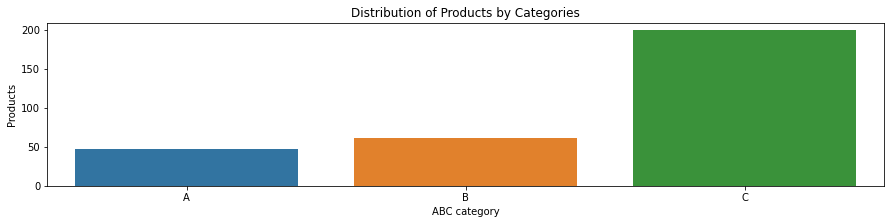

In [213]:
df1_ = df2.groupby('ABC_category')['Product'].count().reset_index()
plt.rcParams['figure.figsize']=(15, 3)
sns.barplot(x = 'ABC_category', y = 'Product', data = df1_)
plt.xlabel("ABC category");
plt.ylabel("Products");
plt.title("Distribution of Products by Categories")

In [ ]:
# Vizualizing the distribution of sales by categories

In [214]:
df1_ = df2.groupby('ABC_category')['Sales'].sum().reset_index()
df1_['Percent']=df1_['Sales']/total_sales*100
df1_

,ABC_category,Sales,Percent
0,A,203449.030233,79.669010
1,B,39044.958140,15.289693
2,C,12873.851163,5.041297


Text(0.5, 1.0, 'Distribution of Sales by Categories')

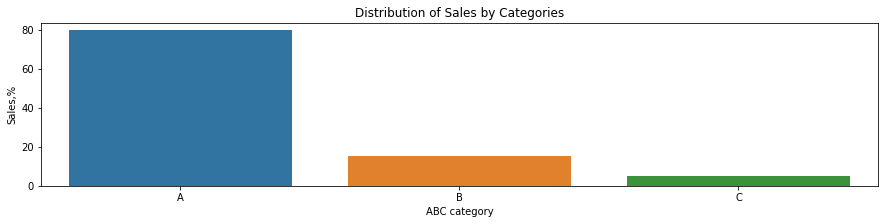

In [215]:
sns.barplot(x = 'ABC_category', y = 'Percent', data = df1_)
plt.xlabel("ABC category");
plt.ylabel("Sales,%");
plt.title("Distribution of Sales by Categories")

In [ ]:
# How many Products were sold vs Category

In [216]:
df1_ = df2.groupby('ABC_category')['Qty'].sum().reset_index()
df1_

,ABC_category,Qty
0,A,16319
1,B,3270
2,C,1323


Text(0.5, 1.0, 'Distribution of total Amount of sold items by Categories')

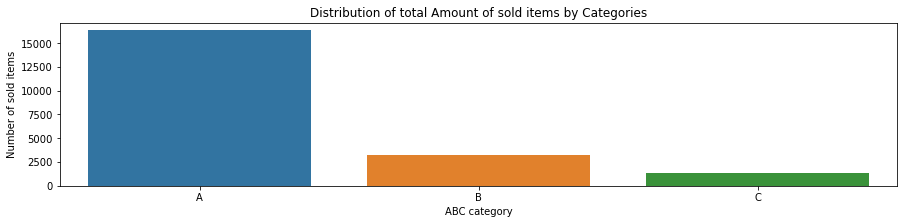

In [217]:
sns.barplot(x = 'ABC_category', y = 'Qty', data = df1_)
plt.xlabel("ABC category");
plt.ylabel("Number of sold items");
plt.title("Distribution of total Amount of sold items by Categories")


### **ABC (Products) analysis conclusions:**

#### 1. There are 47 products in the category A, which is 15% from the total number of products.
#### 2. The category A provides almost 80% of annual sales, and, therefore, these products are of high importance for the company.
#### 3. The high amount of sales in catgory A is not due to the high price of the Products, but because of high numbers of sold items.
#### 4. We need to forecast the sales in the category A, which will be done in the next section.

### 2.a. Sklearn models sales forecating for Category A products 

In [ ]:
# let us consider category A in details and make forecast for sales in this category

In [218]:
df22 = df.merge(df2[['Product', 'ABC_category']], how='inner', on='Product')
df22=df22[df22['ABC_category']=="A"]
df22 = df22[df22['Period'] < '2021-01-01']
df22.head()

,Product,Customer,Order,Qty,Sales,Period,ABC_category
36,Product 2,Customer 2,78554,1,6.093023,2019-02-07 09:42:14,A
37,Product 2,Customer 6,78598,1,5.923256,2019-06-19 23:59:59,A
38,Product 2,Customer 9,78632,1,5.332558,2019-01-07 11:19:41,A
39,Product 2,Customer 9,78635,1,5.332558,2019-01-07 11:24:49,A
40,Product 2,Customer 19,78762,1,5.920930,2019-01-07 15:03:22,A


In [219]:
df22.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20073 entries, 36 to 27762
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Product       20073 non-null  object        
 1   Customer      20073 non-null  object        
 2   Order         20073 non-null  object        
 3   Qty           20073 non-null  int64         
 4   Sales         20073 non-null  float64       
 5   Period        20073 non-null  datetime64[ns]
 6   ABC_category  20073 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 1.2+ MB


In [ ]:
# the most popular Products in category A

In [220]:
df22.Product.value_counts()

Product 25       3165
Product 3        1899
Product 58       1257
Product 23       1252
Product 4         878
Product 2         841
Product 44        731
Product 43        659
Product 46        567
Product 5         539
Product 45        457
Product 27        419
Product 76        411
Product 101       411
Product 74        390
Product 18        390
Product 32        336
Product 17        330
Product 390       319
Product 389       313
Product 41        303
Product 20        276
Product 1974      268
Product 19        265
Product 2214      256
Product 30        250
Product 282       232
Product 9760      226
Product 194       213
Product 188       206
Product 104       199
Product 298       190
Product 40        180
Product 598       179
Product 22        157
Product 82        152
Product 71        152
Product 231       149
Product 311       135
Product 8         114
Product 7          99
Product 328        80
Product 22051      69
Product 673        58
Product 699        57
Product 41

In [ ]:
# we select 5 the most popular Products

In [221]:
df22 = df22[(df22['Product'] == 'Product 25') | (df22['Product'] == 'Product 3') |
          (df22['Product'] == 'Product 4') | (df22['Product'] == 'Product 23') | (df22['Product'] == 'Product 58')]
df22.head()

,Product,Customer,Order,Qty,Sales,Period,ABC_category
913,Product 3,Customer 2,78554,1,3.193023,2019-02-07 09:42:14,A
914,Product 3,Customer 6,78598,1,3.104651,2019-06-19 23:59:59,A
915,Product 3,Customer 9,78632,1,2.795349,2019-01-07 11:19:41,A
916,Product 3,Customer 9,78635,1,2.795349,2019-01-07 11:24:49,A
917,Product 3,Customer 10,78636,1,3.362791,2019-01-07 11:26:24,A


In [ ]:
# preparing the dataframe for applying the models

In [222]:
df22['Period'] = pd.to_datetime(df22['Period']).dt.strftime('%Y-%m')
df22['Period'] = pd.to_datetime(df22['Period'])

df22.drop(['Customer', 'Order', 'Qty', 'ABC_category'], axis=1, inplace=True)
df22.head(2)

,Product,Sales,Period
913,Product 3,3.193023,2019-02-01
914,Product 3,3.104651,2019-06-01


In [223]:
df2_ = df22.pivot_table(index="Period", columns="Product", values="Sales", aggfunc=np.sum)
df2_.head()

Product,Product 23,Product 25,Product 3,Product 4,Product 58
Period,,,,,
2018-01-01,125.965116,52.979070,5.897674,5.811628,57.332558
2018-02-01,45.641860,44.148837,12.888372,12.558140,81.393023
2018-03-01,NaN,27.151163,6.225581,12.269767,78.420930
2018-04-01,47.306977,5.809302,6.555814,NaN,21.195349
2018-05-01,126.316279,92.206977,36.158140,23.506977,190.160465


In [224]:
df3 = df2_.rename_axis(None)
df3.columns.name = None
df3.reset_index(inplace=True)
df3.fillna(0.0, inplace=True)
df3.head()

,index,Product 23,Product 25,Product 3,Product 4,Product 58
0,2018-01-01,125.965116,52.979070,5.897674,5.811628,57.332558
1,2018-02-01,45.641860,44.148837,12.888372,12.558140,81.393023
2,2018-03-01,0.000000,27.151163,6.225581,12.269767,78.420930
3,2018-04-01,47.306977,5.809302,6.555814,0.000000,21.195349
4,2018-05-01,126.316279,92.206977,36.158140,23.506977,190.160465


In [225]:
df4 = df3.copy()
df4 = df4.iloc[-12:, :]
df4.loc[:, ['Product 23', 'Product 25', 'Product 3', 'Product 4', 'Product 58']] = np.nan

def repl(string):
    new_date = string.replace('2020','2021')
    return new_date

df4['index'] = df4['index'].dt.strftime('%Y-%m-%d').map(repl)
df4['index'] = pd.to_datetime(df4['index'])

df4.head()

,index,Product 23,Product 25,Product 3,Product 4,Product 58
24,2021-01-01,NaN,NaN,NaN,NaN,NaN
25,2021-02-01,NaN,NaN,NaN,NaN,NaN
26,2021-03-01,NaN,NaN,NaN,NaN,NaN
27,2021-04-01,NaN,NaN,NaN,NaN,NaN
28,2021-05-01,NaN,NaN,NaN,NaN,NaN


In [226]:
df3 = df3.append(df4)
df3.reset_index(inplace=True)
df3.drop('level_0', axis=1, inplace=True)
df3.head()

,index,Product 23,Product 25,Product 3,Product 4,Product 58
0,2018-01-01,125.965116,52.979070,5.897674,5.811628,57.332558
1,2018-02-01,45.641860,44.148837,12.888372,12.558140,81.393023
2,2018-03-01,0.000000,27.151163,6.225581,12.269767,78.420930
3,2018-04-01,47.306977,5.809302,6.555814,0.000000,21.195349
4,2018-05-01,126.316279,92.206977,36.158140,23.506977,190.160465


In [227]:
df5 = df3.copy()
df5['month_num'] = range(1, len(df5) + 1)

In [228]:
df5['Year'] = df5["index"].dt.year
df5['Month'] = df5["index"].dt.month
df5.drop('index', axis=1, inplace=True)
df5.head(2)

,Product 23,Product 25,Product 3,Product 4,Product 58,month_num,Year,Month
0,125.965116,52.979070,5.897674,5.811628,57.332558,1,2018,1
1,45.641860,44.148837,12.888372,12.558140,81.393023,2,2018,2


In [229]:
year = pd.get_dummies(df5['Year'], drop_first=True).copy()
month = pd.get_dummies(df5['Month'], drop_first=True).copy()
df5.drop(['Year', 'Month'], inplace=True, axis=1)
df5 = pd.concat([df5, year, month], axis=1)
df5.head(2)

,Product 23,Product 25,Product 3,Product 4,Product 58,month_num,2019,2020,2021,2,3,4,5,6,7,8,9,10,11,12
0,125.965116,52.979070,5.897674,5.811628,57.332558,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,45.641860,44.148837,12.888372,12.558140,81.393023,2,0,0,0,1,0,0,0,0,0,0,0,0,0,0


In [ ]:
# making vectors for the modelling

In [230]:
X = df5.iloc[:, 5:]

y_p2  = df5['Product 23']
X1 = X[X.index < 36]
y1_p2 = y_p2[y_p2.index < 36]

In [ ]:
#importing models

In [231]:
from sklearn import set_config
set_config(print_changed_only=False)

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

In [ ]:
# teaching the models

In [232]:
# Linear Regression
lr = LinearRegression()
lr.fit(X1, y1_p2)
pred_lr = lr.predict(X1)
print(lr.score(X1, y1_p2))

# Random Forest
rf = RandomForestRegressor()
rf.fit(X1, y1_p2)
pred_rf = rf.predict(X1)
print(rf.score(X1, y1_p2))

# XGBoost
xgb = XGBRegressor(use_label_encoder=False)
xgb.fit(X1, y1_p2)
pred_xgb = xgb.predict(X1)
print(xgb.score(X1, y1_p2))

0.8066382703119638
0.9421626180244741
0.9999999999981671


Text(0.5, 1.0, 'Real and calculted sales using machine learning models')

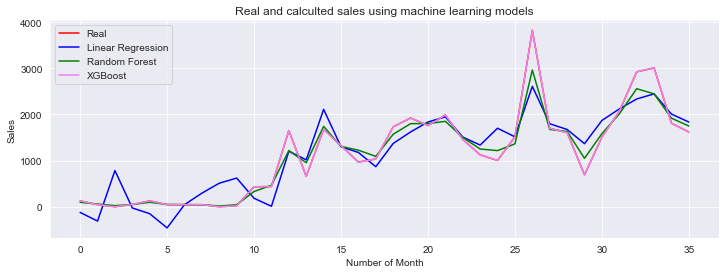

In [233]:
sns.set_style(style='darkgrid')
pd.DataFrame({'Real': y1_p2, 'Linear Regression': pred_lr,'Random Forest': pred_rf, 'XGBoost': pred_xgb}).plot(color=('red', 'blue', 'green', 'violet'), figsize=(12, 4))
plt.xlabel("Number of Month");
plt.ylabel("Sales");
plt.title("Real and calculted sales using machine learning models")

In [ ]:
# XGBoost looks "over-teached", so we exclude it

Text(0.5, 1.0, 'Real and calculted sales using machine learning models')

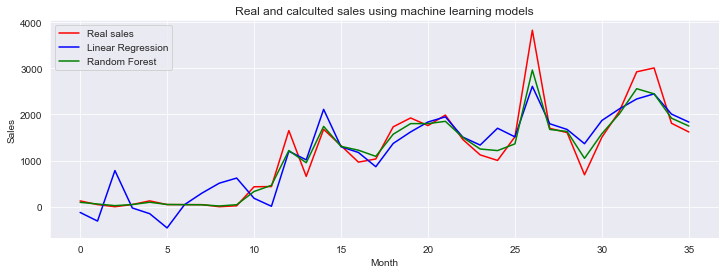

In [234]:
sns.set_style(style='darkgrid')
pd.DataFrame({'Real sales': y1_p2, 'Linear Regression': pred_lr,'Random Forest': pred_rf}).plot(color=('red', 'blue', 'green'), figsize=(12, 4))
plt.xlabel("Month");
plt.ylabel("Sales");
plt.title("Real and calculted sales using machine learning models")

In [ ]:
# Let us use the ensebmble of our models

In [235]:
from sklearn.ensemble import VotingRegressor

In [240]:
VR=VotingRegressor(estimators=[('1',lr),('2', rf),('3', xgb)])
VR.fit(X1, y1_p2)
pred_VR = VR.predict(X1)
VR.score(X1, y1_p2)

0.955307871434095

In [ ]:
# plot the result

Text(0.5, 1.0, 'Real and calculted sales using machine learning models')

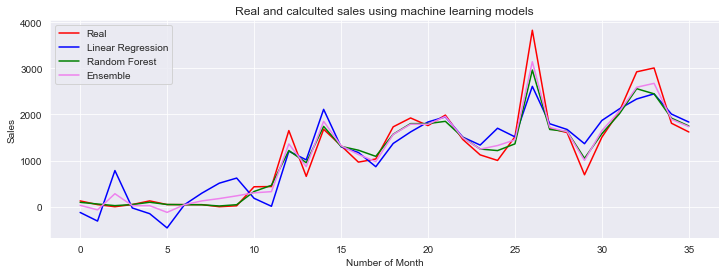

In [241]:
sns.set_style(style='darkgrid')
pd.DataFrame({'Real': y1_p2, 'Linear Regression': pred_lr,'Random Forest': pred_rf, 'Ensemble': pred_VR}).plot(color=('red', 'blue', 'green', 'violet'), figsize=(12, 4))
plt.xlabel("Number of Month");
plt.ylabel("Sales");
plt.title("Real and calculted sales using machine learning models")

In [ ]:
# Sales forecasting

Text(0.5, 1.0, 'Sales forecast for the selected Product 23')

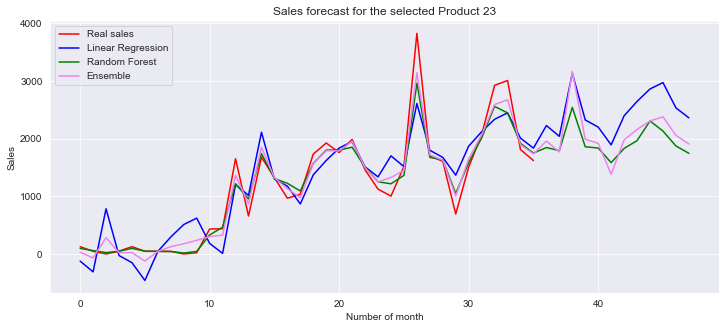

In [244]:
pred_lr = lr.predict(X)
pred_rf = rf.predict(X)
pred_VR = VR.predict(X)
pd.DataFrame({'Real sales': y_p2, 'Linear Regression': pred_lr, 'Random Forest': pred_rf,'Ensemble': pred_VR}).plot(color=('red', 'blue', 'green','violet'), figsize=(12, 5))
plt.xlabel("Number of month");
plt.ylabel("Sales");
plt.title("Sales forecast for the selected Product 23")

### **Machine learning forecast conclusions:**

#### 1. We focused on the Products from A category.
#### 2. For the sales of selected product we applied machine learning algorithms, such as Linear regression, Random forest, and XGboost, as well as the Voting Regressor enseble.
#### 3. The obtained forecast demostrates periodicity in the sales with positive inclination.

### 2. b. Sktime models sales forecating for Category A products

In [ ]:
# preparing the dataframe and cut off 2018 with minor values of sales, which can "confuse" our models, as shown above

In [96]:
df77=df2_.copy()
df77 = df77[df77.index > '2018-12-01']

In [ ]:
# We convert the date format to period format to use models from sktime library

In [97]:
df77.index = df77.index.to_period(freq='M')
df77.fillna(0.01, inplace=True)

In [98]:
df77.head()

Product,Product 23,Product 25,Product 3,Product 4,Product 58
Period,,,,,
2019-01,1650.123256,937.865116,157.081395,199.376744,1099.820930
2019-02,657.520930,1109.913953,369.248837,360.130233,2103.653488
2019-03,1677.697674,1064.586047,587.046512,496.702326,1609.518605
2019-04,1323.702326,967.702326,390.560465,398.127907,1589.969767
2019-05,966.153488,932.481395,290.662791,312.718605,1321.083721


In [ ]:
# let us select 1 product. We do not show analysis for other products in order not to overload the whole project.

In [99]:
df77.drop(['Product 23', 'Product 3', 'Product 4', 'Product 58'], inplace=True, axis=1)
df77.head()

Product,Product 25
Period,
2019-01,937.865116
2019-02,1109.913953
2019-03,1064.586047
2019-04,967.702326
2019-05,932.481395


In [100]:
y = df77.squeeze()
y

Period
2019-01     937.865116
2019-02    1109.913953
2019-03    1064.586047
2019-04     967.702326
2019-05     932.481395
2019-06     782.876744
2019-07    1473.469767
2019-08    1558.748837
2019-09    1679.595349
2019-10    1935.765116
2019-11    1353.000000
2019-12     753.441860
2020-01     596.990698
2020-02    1004.676744
2020-03    1965.058140
2020-04    1789.848837
2020-05     895.153488
2020-06     856.723256
2020-07    1242.697674
2020-08    1721.858140
2020-09    1932.004651
2020-10    2585.772093
2020-11    1558.602326
2020-12     933.062791
Freq: M, Name: Product 25, dtype: float64

In [31]:
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.utils.plotting import plot_series
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split

In [ ]:
# first we teach our model on real sales. Here we make y_test and y_train equal to all data to be able 
# to calculate the errors of our models

In [115]:
y_train, y_test = y,y

In [ ]:
# we import 4 models needed

In [70]:
from sktime.forecasting.theta import ThetaForecaster
from sktime.forecasting.exp_smoothing import ExponentialSmoothing
from sktime.forecasting.ets import AutoETS
from sktime.forecasting.bats import BATS

In [ ]:
# performing fit and prediction

In [116]:
fh = ForecastingHorizon(y.index, is_relative=False)

forecaster1 = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster2 = ThetaForecaster(sp=12)
forecaster3 = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster4 = AutoETS(auto=True, sp=12, n_jobs=-1)


forecaster1.fit(y_train)
forecaster2.fit(y_train)
forecaster3.fit(y_train)
forecaster4.fit(y_train)

# y_pred will contain the predictions
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)
y_pred3 = forecaster3.predict(fh)
y_pred4 = forecaster4.predict(fh)

print(mean_absolute_percentage_error(y_pred1, y_test))
print(mean_absolute_percentage_error(y_pred2, y_test))
print(mean_absolute_percentage_error(y_pred3, y_test))
print(mean_absolute_percentage_error(y_pred4, y_test))

0.13829942134733772
0.14103155341461723
0.19419588869734095
0.11869110941818985


(<Figure size 864x216 with 1 Axes>, <AxesSubplot:ylabel='Product 25'>)

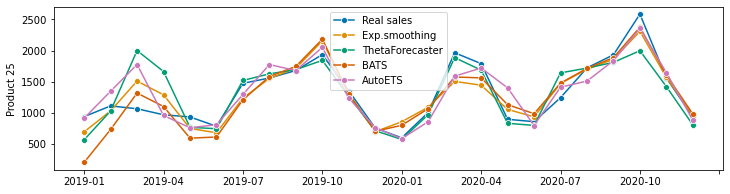

In [117]:
# plotting for illustration

plot_series(y, y_pred1, y_pred2, y_pred3, y_pred4, labels=["Real sales", "Exp.smoothing", "ThetaForecaster", "BATS", "AutoETS"])

In [ ]:
# making the forecast for the next 24 months

(<Figure size 864x216 with 1 Axes>, <AxesSubplot:ylabel='Product 25'>)

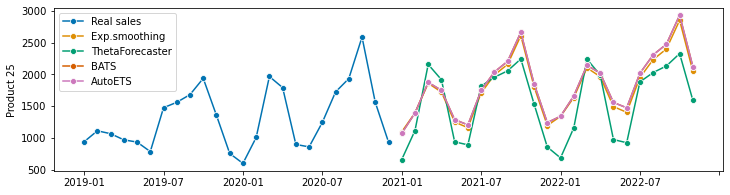

In [118]:
fh = np.arange(1, 24)
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)
y_pred3 = forecaster3.predict(fh)
y_pred4 = forecaster3.predict(fh)


plot_series(y, y_pred1, y_pred2, y_pred3, y_pred4, labels=["Real sales", "Exp.smoothing", "ThetaForecaster", "BATS", "AutoETS"])

### **Sales forecast conclusions:**

#### 1. Again we focused on the Products from A category.
#### 2. For our analysis we selected 1 Product from the group. For the rest products the procedure might be done in the same way.
#### 3. Here we used models offered by sktime library, such as Exponential smoothing, Thetaforecaster, BATS, and Auto ETS.  These models are aimed to work with time series, which is our case.
#### 4. Qualitative analysis of the obtained foresasts shows the presence of periodic sales maxima with general positive inclination. These results are in the good agreement with forecasts obtained in the previous section.
#### 5. Despite the similarity in learning reuslts, models provided the different forecasts. Exponential smoothing, BATS, and Auto ETS provide consistent results. The forecast of Thetaforecaster differs by absolute values.

## 3. ABC analysis by Customer

In [ ]:
# Modifying the inital dataset: looking at year 2020, and taking needed columns

In [246]:
df10 = df[df['Period'] > '2019-12-31']
df10 = df10[df10['Period'] < '2021-01-01']
df10 = df10[['Customer', 'Sales', 'Qty', 'Period']]
df10.head()

,Customer,Sales,Qty,Period
12266,Customer 22,26.467442,1,2020-01-21 13:01:25
12267,Customer 22,24.246512,1,2020-01-21 13:01:25
12268,Customer 22,71.095349,1,2020-01-21 13:01:25
12269,Customer 22,53.583721,1,2020-01-21 13:01:25
12284,Customer 440,209.432558,4,2020-03-03 12:05:27


In [ ]:
# Getting sum of sales of products and sorting them

In [247]:
df20 = df10.groupby('Customer')['Sales', 'Qty'].sum().reset_index()
df20.sort_values('Sales', inplace=True, ascending = False)
df20.head()

<ipython-input-247-9d4a61feff78>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  df20 = df10.groupby('Customer')['Sales', 'Qty'].sum().reset_index()


,Customer,Sales,Qty
695,Customer 9,15966.820930,1493
95,Customer 20,10470.960465,730
112,Customer 218,7236.995349,456
114,Customer 22,6557.979070,306
67,Customer 172,4023.130233,325


In [ ]:
# Calculating the total amount of sales

In [248]:
total_sales = df20['Sales'].sum()
total_sales

255367.83953488368

In [ ]:
# Calculating the Fraction in %

In [249]:
df20['Fraction'] = df20['Sales']/total_sales*100
df20.head(2)

,Customer,Sales,Qty,Fraction
695,Customer 9,15966.820930,1493,6.252479
95,Customer 20,10470.960465,730,4.100344


In [ ]:
# Calculating the accumullated Fraction in %

In [250]:
df20['Percent'] = df20['Fraction'].cumsum()
df20.head(2)

,Customer,Sales,Qty,Fraction,Percent
695,Customer 9,15966.820930,1493,6.252479,6.252479
95,Customer 20,10470.960465,730,4.100344,10.352823


In [ ]:
# Structuring the customers into A,B,C categories

In [251]:
def group(perc):
    if perc <= 80:
        return 'A'
    elif perc > 80 and perc <= 95:
        return 'B'
    else:
        return 'C'

df20['ABC_category'] = df20['Percent'].map(group) #adding the category
df20.head()

,Customer,Sales,Qty,Fraction,Percent,ABC_category
695,Customer 9,15966.820930,1493,6.252479,6.252479,A
95,Customer 20,10470.960465,730,4.100344,10.352823,A
112,Customer 218,7236.995349,456,2.833949,13.186773,A
114,Customer 22,6557.979070,306,2.568052,15.754825,A
67,Customer 172,4023.130233,325,1.575426,17.330250,A


In [ ]:
# Calculating the number of customers in each category and vizualizing this distribution

In [252]:
df20['ABC_category'].value_counts()

C    330
B    203
A    171
Name: ABC_category, dtype: int64

Text(0.5, 1.0, 'Distribution of Customers by Categories')

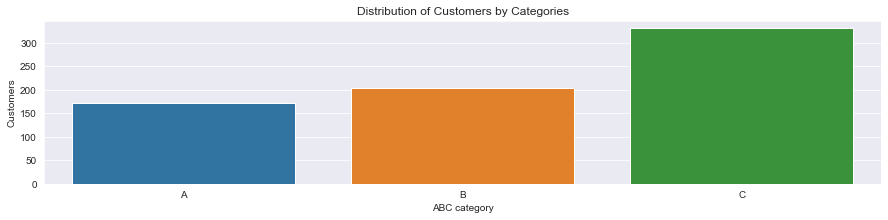

In [254]:
df10_ = df20.groupby('ABC_category')['Customer'].count().reset_index()
plt.rcParams['figure.figsize']=(15, 3)
sns.barplot(x = 'ABC_category', y = 'Customer', data = df10_)
plt.xlabel("ABC category");
plt.ylabel("Customers");
plt.title("Distribution of Customers by Categories")

In [ ]:
# Vizualizing the distribution of sales by categories

In [256]:
df10_ = df20.groupby('ABC_category')['Sales'].sum().reset_index()
df10_['Percent']=df10_['Sales']/total_sales*100
df10_

,ABC_category,Sales,Percent
0,A,204034.146512,79.898137
1,B,38539.616279,15.091805
2,C,12794.076744,5.010058


Text(0.5, 1.0, 'Distribution of Sales by Categories')

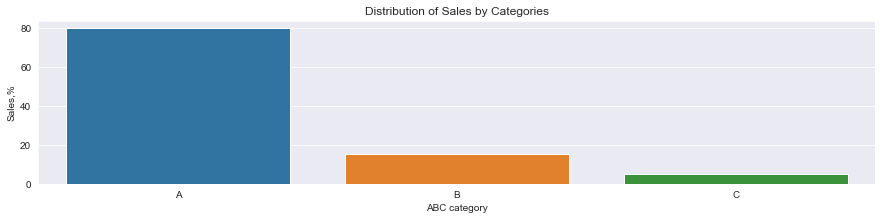

In [257]:
sns.barplot(x = 'ABC_category', y = 'Percent', data = df10_)
plt.xlabel("ABC category");
plt.ylabel("Sales,%");
plt.title("Distribution of Sales by Categories")

### **ABC (Customers) analysis conclusions:**

#### 1. There are 171 customers in the category A, who is 24% from the total number of customers.
#### 2. The category A provides almost 80% of annual sales, and, therefore, these customers are of high importance for the company.
#### 3. We need to focus on forecasting of sales provided by these customers.

### 3.a Sktime models sales forecating for Category A Customers

In [ ]:
# preparing the dataframe

In [272]:
df25 = df.merge(df20[['Customer', 'ABC_category']], how='inner', on='Customer')
df25=df25[df25['ABC_category']=="A"]
df25 = df25[df25['Period'] < '2021-01-01']

In [274]:
df25.Customer.value_counts()

Customer 9      1680
Customer 218     619
Customer 136     432
Customer 15      385
Customer 10      379
                ... 
Customer 677      14
Customer 545      14
Customer 711      12
Customer 756      10
Customer 694      10
Name: Customer, Length: 171, dtype: int64

In [ ]:
# we select 5 the most active Customers

In [275]:
df25 = df25[(df25['Customer'] == 'Customer 9') | (df25['Customer'] == 'Customer 218') |
          (df25['Customer'] == 'Customer 136') | (df25['Customer'] == 'Customer 15') | (df25['Customer'] == 'Customer 10')]
df25.head()

,Product,Customer,Order,Qty,Sales,Period,ABC_category
714,Product 22,Customer 9,78624,1,21.406977,2019-01-07 11:08:07,A
715,Product 23,Customer 9,78624,2,38.967442,2019-01-07 11:08:07,A
716,Product 17,Customer 9,78624,1,12.190698,2019-01-07 11:08:07,A
717,Product 25,Customer 9,78624,2,9.909302,2019-01-07 11:08:07,A
718,Product 26,Customer 9,78624,1,9.067442,2019-01-07 11:08:07,A


In [ ]:
# preparing the dataframe for applying the models

In [276]:
df25['Period'] = pd.to_datetime(df25['Period']).dt.strftime('%Y-%m')
df25['Period'] = pd.to_datetime(df25['Period'])

df25.drop(['Product', 'Order', 'Qty', 'ABC_category'], axis=1, inplace=True)
df25.head(2)

,Customer,Sales,Period
714,Customer 9,21.406977,2019-01-01
715,Customer 9,38.967442,2019-01-01


In [277]:
df3_ = df25.pivot_table(index="Period", columns="Customer", values="Sales", aggfunc=np.sum)
df3_.head()

Customer,Customer 10,Customer 136,Customer 15,Customer 218,Customer 9
Period,,,,,
2018-02-01,82.25814,NaN,NaN,NaN,39.846512
2018-03-01,NaN,98.911628,NaN,NaN,NaN
2018-05-01,NaN,NaN,NaN,NaN,99.665116
2018-06-01,NaN,48.672093,NaN,153.688372,69.304651
2018-08-01,NaN,NaN,NaN,NaN,110.016279


In [ ]:
# preparing the dataframe and cut off 2018 with minor values of sales, which can "confuse" our models, as shown above

In [278]:
df78=df3_.copy()
df78 = df78[df78.index > '2018-12-01']

In [ ]:
# We convert the date format to period format to use models from sktime library

In [279]:
df78.index = df78.index.to_period(freq='M')
df78.fillna(0.01, inplace=True)

In [280]:
df78.head()

Customer,Customer 10,Customer 136,Customer 15,Customer 218,Customer 9
Period,,,,,
2019-01,123.704651,209.713953,187.962791,0.010000,895.490698
2019-02,46.283721,158.574419,0.010000,474.800000,1035.390698
2019-03,54.395349,94.381395,42.283721,1259.844186,1499.655814
2019-04,11.106977,352.988372,170.725581,455.293023,1133.016279
2019-05,0.010000,212.069767,142.588372,695.672093,661.774419


In [ ]:
# let us select  customer 9. We do not show analysis for other products in order not to overload the whole project.

In [281]:
df78.drop(['Customer 10', 'Customer 136', 'Customer 15', 'Customer 218'], inplace=True, axis=1)
df78.head()

Customer,Customer 9
Period,
2019-01,895.490698
2019-02,1035.390698
2019-03,1499.655814
2019-04,1133.016279
2019-05,661.774419


In [282]:
y3 = df78.squeeze()
y3

Period
2019-01     895.490698
2019-02    1035.390698
2019-03    1499.655814
2019-04    1133.016279
2019-05     661.774419
2019-06     512.351163
2019-07     543.462791
2019-08    1059.720930
2019-09    1216.265116
2019-10    1234.225581
2019-11     646.416279
2019-12     565.623256
2020-01    1182.560465
2020-02    1474.774419
2020-03    1498.118605
2020-04    2675.481395
2020-05     650.600000
2020-06     682.718605
2020-07    1699.467442
2020-08     722.311628
2020-09    1010.858140
2020-10    3269.313953
2020-11     401.904651
2020-12     698.711628
Freq: M, Name: Customer 9, dtype: float64

In [ ]:
# first we teach our model on real sales. Here we make y_test and y_train equal to all data to be able 
# to calculate the errors of our models

In [283]:
y_train, y_test = y3,y3

In [ ]:
# we will use 4 models as above

In [ ]:
# performing fit and prediction

In [284]:
fh = ForecastingHorizon(y.index, is_relative=False)

forecaster1 = ExponentialSmoothing(trend="add", seasonal="additive", sp=12)
forecaster2 = ThetaForecaster(sp=12)
forecaster3 = BATS(sp=12, use_trend=True, use_box_cox=False)
forecaster4 = AutoETS(auto=True, sp=12, n_jobs=-1)


forecaster1.fit(y_train)
forecaster2.fit(y_train)
forecaster3.fit(y_train)
forecaster4.fit(y_train)

# y_pred will contain the predictions
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)
y_pred3 = forecaster3.predict(fh)
y_pred4 = forecaster4.predict(fh)

print(mean_absolute_percentage_error(y_pred1, y_test))
print(mean_absolute_percentage_error(y_pred2, y_test))
print(mean_absolute_percentage_error(y_pred3, y_test))
print(mean_absolute_percentage_error(y_pred4, y_test))

0.34487557286585774
0.24817547783738955
0.24580144032162968
0.2192396332876572


(<Figure size 864x216 with 1 Axes>, <AxesSubplot:ylabel='Customer 9'>)

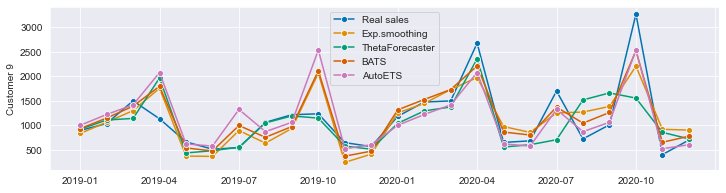

In [286]:
# plotting for illustration

plot_series(y3, y_pred1, y_pred2, y_pred3, y_pred4, labels=["Real sales", "Exp.smoothing", "ThetaForecaster", "BATS", "AutoETS"])

In [ ]:
# making the forecast for the next 24 months

(<Figure size 864x216 with 1 Axes>, <AxesSubplot:ylabel='Customer 9'>)

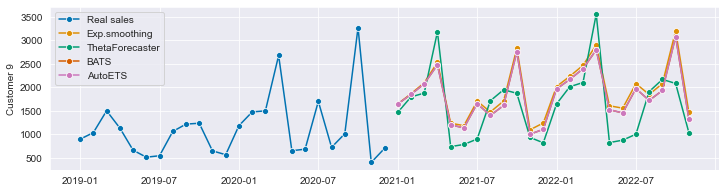

In [288]:
fh = np.arange(1, 24)
y_pred1 = forecaster1.predict(fh)
y_pred2 = forecaster2.predict(fh)
y_pred3 = forecaster3.predict(fh)
y_pred4 = forecaster3.predict(fh)


plot_series(y3, y_pred1, y_pred2, y_pred3, y_pred4, labels=["Real sales", "Exp.smoothing", "ThetaForecaster", "BATS", "AutoETS"])

### **Sales forecast conclusions:**

#### 1. Here we focused on the Customers from A category.
#### 2. For our analysis we selected 1 Customer from the group. For the rest customers the procedure might be done in the same way.
#### 3. Here we used models offered by sktime library, such as Exponential smoothing, Thetaforecaster, BATS, and Auto ETS.  These models are aimed to work with time series, which is our case.
#### 4. Qualitative analysis of the obtained foresasts shows the presence of periodic sales maxima with general positive inclination. These results are in the good agreement with forecasts obtained in the previous section.
#### 5. Despite the similarity in learning reuslts, models provided the different forecasts. Exponential smoothing, BATS, and Auto ETS provide consistent results. The forecast of Thetaforecaster differs by absolute values.